<a href="https://colab.research.google.com/github/dcovarru/Python/blob/master/Covid.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#####################
# Import packages
#####################

import pandas as pd
import dateutil
import datetime
import numpy as np
import pandas_datareader
import pandas_datareader.data as web
from pandas_datareader.data import get_quote_yahoo
import matplotlib.pyplot as plt
from pandas import Series, DataFrame
from pandas.plotting import scatter_matrix
import os
import re
import plotly.figure_factory as ff
import plotly as py
import plotly.offline as offline
import plotly.graph_objects as go
import plotly.express as px
from google.colab import drive
plt.style.use('seaborn-whitegrid')
import io

import seaborn as sns
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/pandas_datareader/compat/__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


In [0]:
#####################
# Import NYT data 
#####################

covidData = pd.read_csv('https://github.com/nytimes/covid-19-data/raw/master/us-counties.csv')

# https://github.com/nytimes/covid-19-data
# https://github.com/CSSEGISandData/COVID-19/tree/master/csse_covid_19_data

#####################
# helper sites #
#####################

# https://medium.com/@deallen7/managing-date-datetime-and-timestamp-in-python-pandas-cc9d285302ab#83e5
# https://www.shanelynn.ie/summarising-aggregation-and-grouping-data-in-python-pandas/

In [3]:
covidData.head()

,date,county,state,fips,cases,deaths
0,2020-01-21,Snohomish,Washington,53061.0,1,0
1,2020-01-22,Snohomish,Washington,53061.0,1,0
2,2020-01-23,Snohomish,Washington,53061.0,1,0
3,2020-01-24,Cook,Illinois,17031.0,1,0
4,2020-01-24,Snohomish,Washington,53061.0,1,0


In [0]:
# ensure Date is data
# covidData.dtypes
# covidData['date'] = covidData['date'].apply(dateutil.parser.parse, dayfirst=True)
covidData['date_dtFormat'] = pd.to_datetime(covidData['date'])
# covidData

In [0]:
covidData.dtypes

date                     object
county                   object
state                    object
fips                    float64
cases                     int64
deaths                    int64
date_dtFormat    datetime64[ns]
dtype: object

In [0]:
#####################
# ETL data 
#####################
covidData[['date_dtFormat']]
covidData.loc[:,['date_dtFormat']]

,date_dtFormat
0,2020-01-21
1,2020-01-22
2,2020-01-23
3,2020-01-24
4,2020-01-24
...,...
123944,2020-05-07
123945,2020-05-07
123946,2020-05-07
123947,2020-05-07


In [0]:
covidData

,date,county,state,fips,cases,deaths,date_dtFormat
0,2020-01-21,Snohomish,Washington,53061.0,1,0,2020-01-21
1,2020-01-22,Snohomish,Washington,53061.0,1,0,2020-01-22
2,2020-01-23,Snohomish,Washington,53061.0,1,0,2020-01-23
3,2020-01-24,Cook,Illinois,17031.0,1,0,2020-01-24
4,2020-01-24,Snohomish,Washington,53061.0,1,0,2020-01-24
...,...,...,...,...,...,...,...
123944,2020-05-07,Sublette,Wyoming,56035.0,3,0,2020-05-07
123945,2020-05-07,Sweetwater,Wyoming,56037.0,19,0,2020-05-07
123946,2020-05-07,Teton,Wyoming,56039.0,98,1,2020-05-07
123947,2020-05-07,Uinta,Wyoming,56041.0,8,0,2020-05-07


In [0]:
#####################
# Aggregate by Week
#####################

# covidData.tail(30)
# df['date_time'].dt.strftime('%Y-%U')
# covidData['date_dtFormat'].dt.strftime('%Y-%w')
# covidData['date_dtFormat2'] = covidData['date_dtFormat'].dt.strftime('"%A %d %B %Y"')
# covidData['date_dtFormat'].dt.strftime('%b %d %Y')

# Extract Week
covidData['data_week'] = covidData['date_dtFormat'].dt.week
# Extract Month
covidData['data_month'] = covidData['date_dtFormat'].dt.month
# Extract DOW
covidData['data_dow'] = covidData['date_dtFormat'].dt.dayofweek

In [0]:
################################
# Calculate Difference for Daily Total
################################

## covidData['daily_deaths'] = covidData['deaths'].diff()
# covidData.groupby['deaths'].diff()
# df.groupby(level=0)['values'].diff()
covidData['daily_cases'] = covidData.groupby(['state', 'county'])['cases'].diff()
covidData['daily_deaths'] = covidData.groupby(['state', 'county'])['deaths'].diff()
# covidData.shape

In [0]:
covidData.tail()

,date,county,state,fips,cases,deaths,date_dtFormat,data_week,data_month,data_dow,daily_cases,daily_deaths
123944,2020-05-07,Sublette,Wyoming,56035.0,3,0,2020-05-07,19,5,3,0.0,0.0
123945,2020-05-07,Sweetwater,Wyoming,56037.0,19,0,2020-05-07,19,5,3,0.0,0.0
123946,2020-05-07,Teton,Wyoming,56039.0,98,1,2020-05-07,19,5,3,0.0,0.0
123947,2020-05-07,Uinta,Wyoming,56041.0,8,0,2020-05-07,19,5,3,0.0,0.0
123948,2020-05-07,Washakie,Wyoming,56043.0,7,0,2020-05-07,19,5,3,0.0,0.0


In [0]:
################################
# Verify data
################################

covidData[(covidData.state == 'Wyoming') & (covidData.county=='Washakie')].tail(20)

,date,county,state,fips,cases,deaths,date_dtFormat,data_week,data_month,data_dow,daily_cases,daily_deaths
70069,2020-04-18,Washakie,Wyoming,56043.0,4,0,2020-04-18,16,4,5,0.0,0.0
72836,2020-04-19,Washakie,Wyoming,56043.0,4,0,2020-04-19,16,4,6,0.0,0.0
75609,2020-04-20,Washakie,Wyoming,56043.0,4,0,2020-04-20,17,4,0,0.0,0.0
78389,2020-04-21,Washakie,Wyoming,56043.0,4,0,2020-04-21,17,4,1,0.0,0.0
81180,2020-04-22,Washakie,Wyoming,56043.0,4,0,2020-04-22,17,4,2,0.0,0.0
83980,2020-04-23,Washakie,Wyoming,56043.0,8,0,2020-04-23,17,4,3,4.0,0.0
86785,2020-04-24,Washakie,Wyoming,56043.0,8,0,2020-04-24,17,4,4,0.0,0.0
89598,2020-04-25,Washakie,Wyoming,56043.0,8,0,2020-04-25,17,4,5,0.0,0.0
92413,2020-04-26,Washakie,Wyoming,56043.0,8,0,2020-04-26,17,4,6,0.0,0.0
95241,2020-04-27,Washakie,Wyoming,56043.0,8,0,2020-04-27,18,4,0,0.0,0.0


In [0]:
####################
# Create aggreate Week Month Counts (yay...)
#####################

# df.groupby(['Name', 'Fruit'])['Number'].agg('sum')
# covidData.groupby(['data_week']).sum()
#################################################
# Below is aggregate the sum by dimensions 
#################################################
# covidData_aggState = covidData.groupby(['state','data_week'])['deaths'].agg('sum').to_frame().reset_index()

covidData_aggState = covidData.groupby(['state','county','data_week'], as_index=False)['daily_deaths'].sum()
# covidData_aggState = covidData.groupby(['state','county','data_week'], as_index=False)['daily_cases'].sum()

In [0]:
covidData_aggState

,state,county,data_week,daily_deaths
0,Alabama,Autauga,13,0.0
1,Alabama,Autauga,14,0.0
2,Alabama,Autauga,15,1.0
3,Alabama,Autauga,16,1.0
4,Alabama,Autauga,17,0.0
...,...,...,...,...
20234,Wyoming,Washakie,15,0.0
20235,Wyoming,Washakie,16,0.0
20236,Wyoming,Washakie,17,0.0
20237,Wyoming,Washakie,18,0.0


In [0]:
# covidData_aggState.to_frame().reset_index()
## covidData_aggState[covidData_aggState.state=='Texas']
covidData_aggState[(covidData_aggState['state'] == "Texas") & (covidData_aggState['county'].isin(['Harris']))].tail(20)

,state,county,data_week,daily_deaths
16997,Texas,Harris,10,0.0
16998,Texas,Harris,11,0.0
16999,Texas,Harris,12,1.0
17000,Texas,Harris,13,3.0
17001,Texas,Harris,14,16.0
17002,Texas,Harris,15,24.0
17003,Texas,Harris,16,31.0
17004,Texas,Harris,17,18.0
17005,Texas,Harris,18,40.0
17006,Texas,Harris,19,21.0


In [0]:
#################################################
# Extract State, County, Start of Week, DOW = 0, and DATE table 
#################################################

covidData_Calendar = covidData[['state', 'county', 'date','data_week','data_dow']].drop_duplicates()[covidData.data_dow == 0]

In [0]:
covidData_aggState_weekly = covidData_aggState.merge(covidData_Calendar, how = 'right', on=['state', 'county', 'data_week'], indicator=True)

In [0]:
covidData_aggState


,state,county,data_week,daily_deaths
0,Alabama,Autauga,13,0.0
1,Alabama,Autauga,14,0.0
2,Alabama,Autauga,15,1.0
3,Alabama,Autauga,16,1.0
4,Alabama,Autauga,17,0.0
...,...,...,...,...
20234,Wyoming,Washakie,15,0.0
20235,Wyoming,Washakie,16,0.0
20236,Wyoming,Washakie,17,0.0
20237,Wyoming,Washakie,18,0.0


In [0]:
#################################################
# Difference data to get weekly volume 
#################################################

# covidData_aggState[(covidData_aggState['state'] == "Texas") & (covidData_aggState['county'].isin(['Bexar']))]['deaths'].diff(periods=1)
covidData_temp = covidData_aggState_weekly[(covidData_aggState_weekly['state'] == "Texas") & (covidData_aggState_weekly['county'].isin(['Dallas']))].sort_values(by=['date'])
covidData_temp

,state,county,data_week,daily_deaths,date,data_dow,_merge
14618,Texas,Dallas,12,2.0,2020-03-16,0,both
14619,Texas,Dallas,13,7.0,2020-03-23,0,both
14620,Texas,Dallas,14,9.0,2020-03-30,0,both
14621,Texas,Dallas,15,13.0,2020-04-06,0,both
14622,Texas,Dallas,16,29.0,2020-04-13,0,both
14623,Texas,Dallas,17,22.0,2020-04-20,0,both
14624,Texas,Dallas,18,29.0,2020-04-27,0,both
14625,Texas,Dallas,19,14.0,2020-05-04,0,both


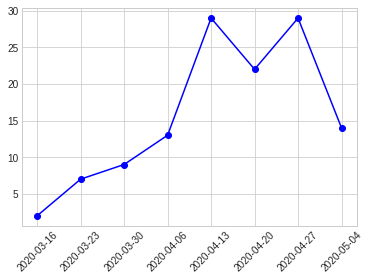

In [0]:
# covidTrace = go.Bar(x = covidData_temp.date, y = covidData_temp.daily_cases)
# fig = go.Figure(data = [covidTrace])
# plotly.offline.plot(fig)

# fig = go.box(covidData_temp, y='daily_cases')
# fig.show()

fig = plt.figure()
ax = plt.axes()
plt.xticks(rotation=45)
ax.plot(covidData_temp.date, covidData_temp.daily_deaths, marker='o', color='b')

[Text(0, 0, '2020-03-30'),
 Text(0, 0, '2020-04-06'),
 Text(0, 0, '2020-04-13'),
 Text(0, 0, '2020-04-20'),
 Text(0, 0, '2020-04-27'),
 Text(0, 0, '2020-05-04'),
 Text(0, 0, '2020-03-16'),
 Text(0, 0, '2020-03-23'),
 Text(0, 0, '2020-01-27'),
 Text(0, 0, '2020-02-03'),
 Text(0, 0, '2020-02-10'),
 Text(0, 0, '2020-02-17'),
 Text(0, 0, '2020-02-24'),
 Text(0, 0, '2020-03-02'),
 Text(0, 0, '2020-03-09')]

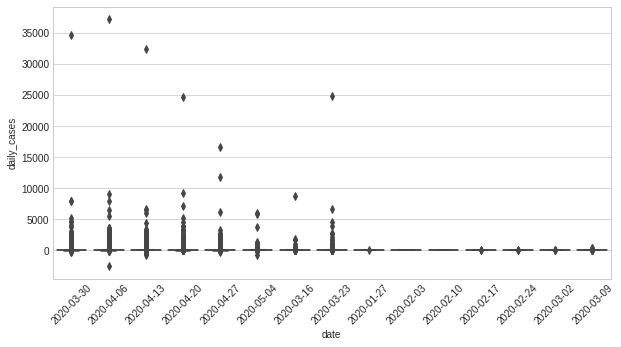

In [0]:
plt.figure(figsize=(10,5))
ax = sns.boxplot(x="date", y="daily_cases", data=covidData_aggState_weekly)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

In [0]:
#####################
# Create Model with metrics?
#####################

In [0]:
#####################
# Trend Diagnostics
#####################